# 0.0 IMPORTS

In [1]:
!pip install xgboost

cryptography 3.3.1 has requirement cffi>=1.12, but you'll have cffi 1.11.5 which is incompatible.
You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
!pip install matplotlib

cryptography 3.3.1 has requirement cffi>=1.12, but you'll have cffi 1.11.5 which is incompatible.
You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
!pip install Boruta

cryptography 3.3.1 has requirement cffi>=1.12, but you'll have cffi 1.11.5 which is incompatible.
You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
!pip install sklearn

cryptography 3.3.1 has requirement cffi>=1.12, but you'll have cffi 1.11.5 which is incompatible.
You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [5]:
import pandas as pd
import inflection
import math
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from matplotlib            import pyplot as plt
from IPython.display       import Image
from scipy                 import stats
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 0.1 Helper Functions

In [6]:
def cramer_v(x, y):
    cm=pd.crosstab(x,y).as_matrix()
    n=cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    
    kcorr=k-(k-1)**2/(n-1)
    rcorr=r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [7]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory= False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [8]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
656362,413,3,2013-11-20,8040,982,1,1,0,0,a,c,760.0,9.0,2014.0,0,NaN,NaN,NaN


# 1.0 PASSO 1 - DESCRICAO DOS DADOS

In [9]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [11]:
print ('Number of Rows: {}'.format (df1.shape[0]))
print ('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [12]:
df1['date']= pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [14]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',11:'Nov',12:'Dec' }

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [15]:
df1.sample(5).T

,745357,914314,977691,403683,422243
store,208,800,622,1043,444
day_of_week,7,3,2,7,3
date,2013-09-01 00:00:00,2013-04-03 00:00:00,2013-02-05 00:00:00,2014-07-06 00:00:00,2014-06-18 00:00:00
sales,0,4489,4617,0,10896
customers,0,454,427,0,1217
open,0,1,1,0,1
promo,0,0,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,0
store_type,c,d,a,c,c


## 1.6 Changes Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

In [18]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

## 1.7 Descriptive Statistical

In [19]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [20]:
#Central Tendency -mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

#Dispersion -std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2,d3,d4, ct1, ct2, d1,d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1.0,2015.0,2014.0,1372.032482,2006.0,932.640284,-0.782151,-1.388100


C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


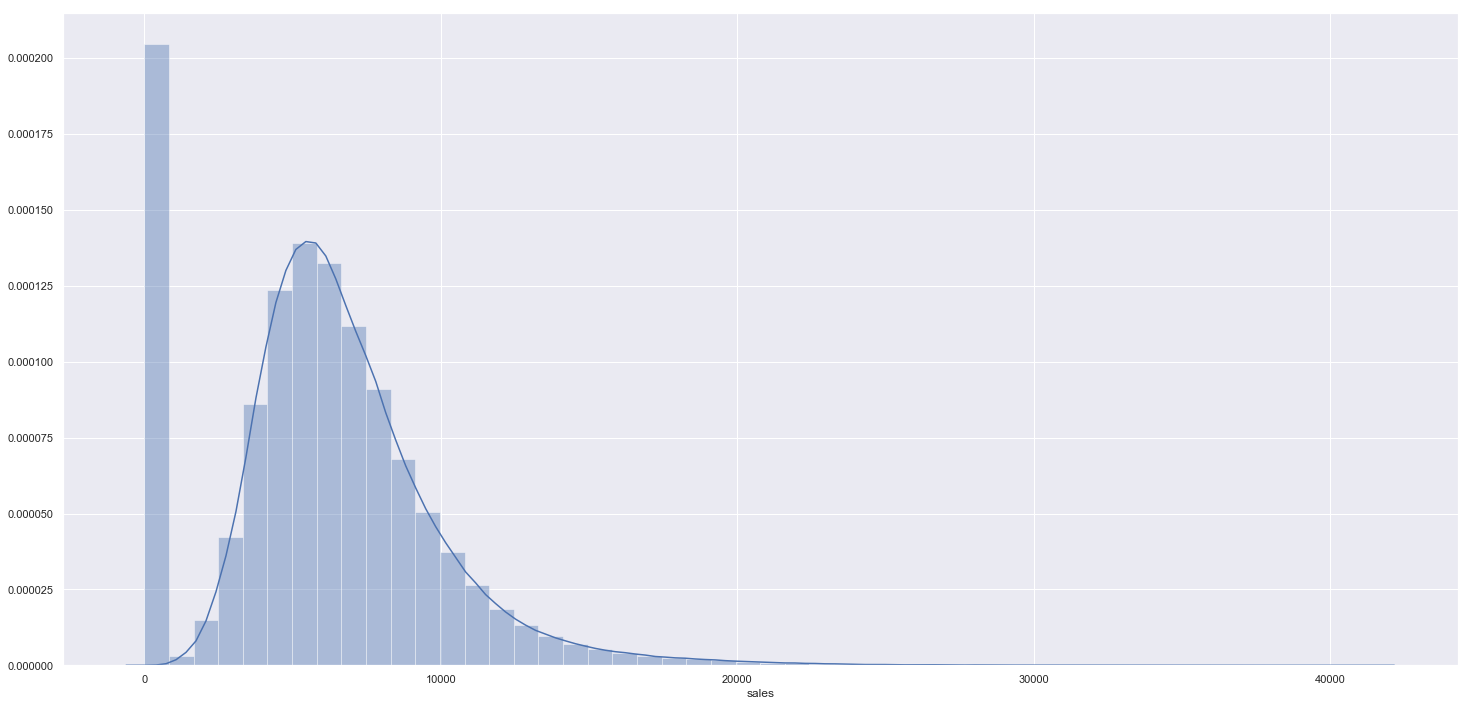

In [21]:
sns.distplot(df1['sales'])

## 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

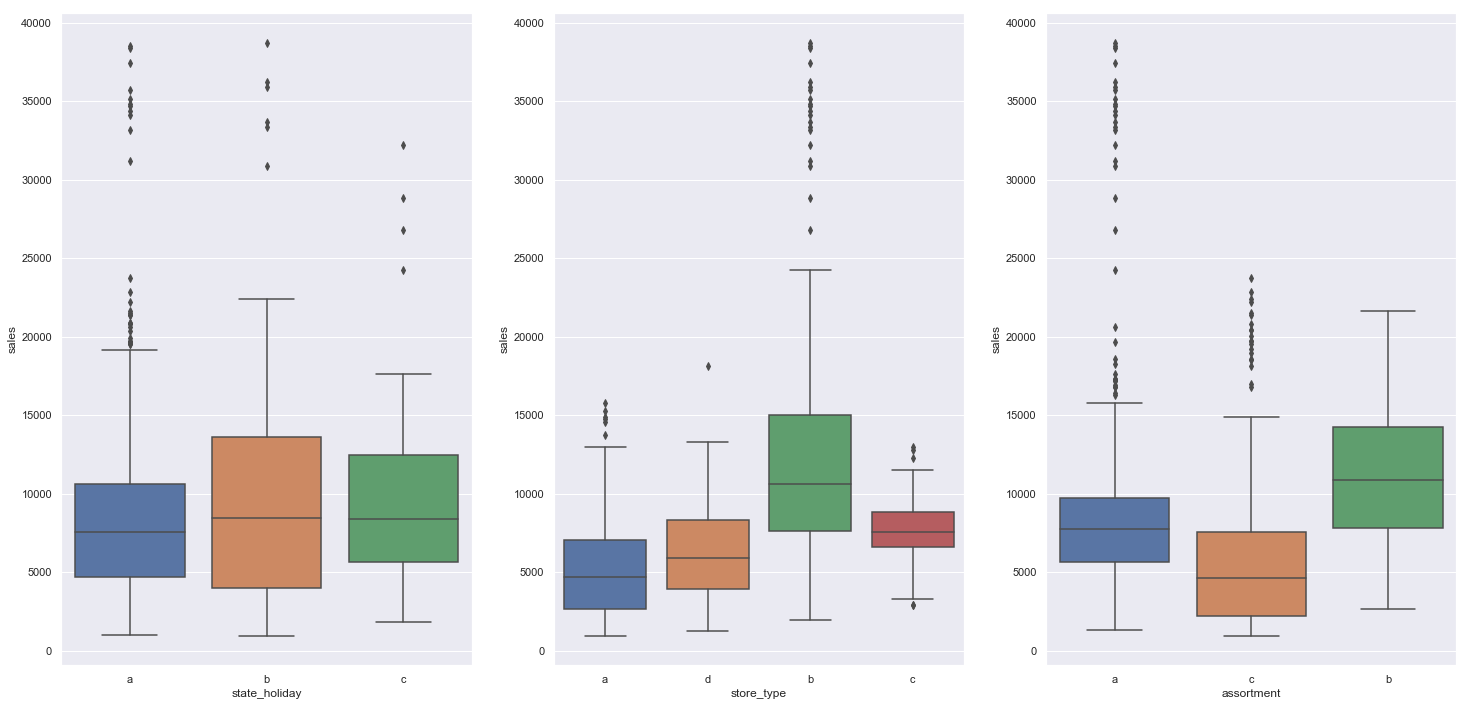

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y='sales', data=aux1)

# 2.0 PASSO 2 - FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## Mapa Mental das Hipótese

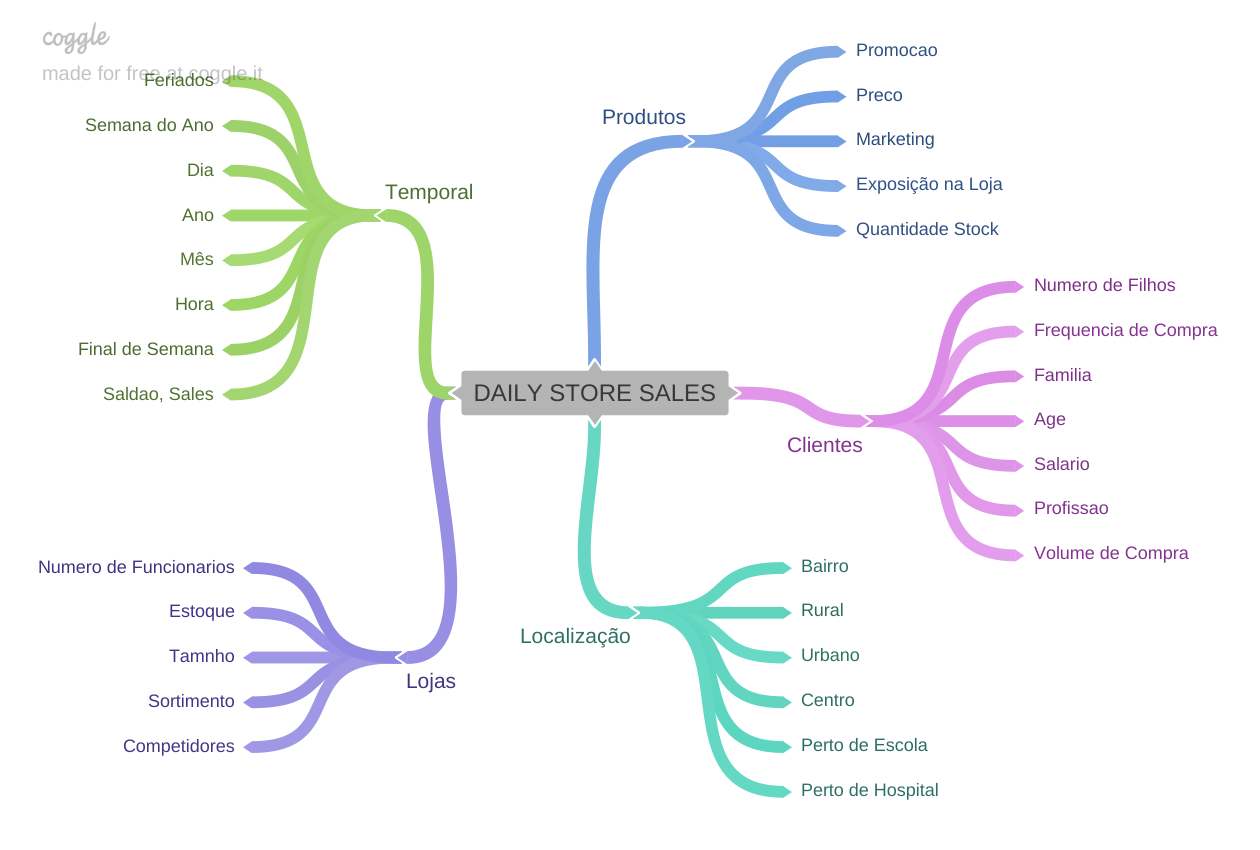

In [24]:
Image('img/MindMapHypothesis.png')

## 2.1 Criação das Hipóteses

## 2.1.1 Hipótese Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tenpo deveriam vender mais.

## 2.1.2 Hipótese Produto

**1.** Lojas que investiam mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoção mais agressivas(descontos maiores), deveriam vender mais.

**5.** Lojas com promoção ativas por tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

## 2.1.3 Hipótese Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tenpo deveriam vender mais.

**4.** Lojas com promoção ativas por tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering 

In [25]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#compettion since
#df2['competition_since']=pd.Timestamp(df2['competition_since'])
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
#df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')) - datetime.timedelta(days=7)                              
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int) 

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x=='b' else 'extended')
                                 
#state holiday
df2['state_holiday']=  df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a'  else 'easter_holiday' if  x=='b' else 'Christmas' if x=='c' else x=='regular_day')

In [27]:
df2['competition_since']=pd.to_datetime(df2['competition_since'], errors = 'coerce')

In [28]:
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days)

In [29]:
df2.sample(5).T

,776211,257772,970347,237947,264553
store,957,983,1083,761,152
day_of_week,1,2,2,2,1
date,2013-08-05 00:00:00,2014-12-09 00:00:00,2013-02-12 00:00:00,2014-12-30 00:00:00,2014-12-01 00:00:00
sales,8819,8447,3112,11551,9132
customers,981,1193,250,1161,861
open,1,1,1,1,1
promo,0,0,0,0,1
state_holiday,False,False,False,False,False
school_holiday,0,0,0,1,0
store_type,d,a,d,a,a


In [30]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                       0
month_map                            0
is_promo                             0
year                                 0
month                                0
day                                  0
week_of_year                         0
year_week                            0
competition_since        

In [31]:
df2['competition_time_month'].max()

1407.0

In [32]:
df2['competition_time_month'] = df2['competition_time_month'].apply(lambda x: '1408' if math.isnan(x) else x)

# 3.0 PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [33]:
df3=df2.copy()

In [34]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week,competition_time_month
0,1,5,2015-07-31,5263,555,1,1,False,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0,84
1,2,5,2015-07-31,6064,625,1,1,False,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279,94
2,3,5,2015-07-31,8314,821,1,1,False,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226,105
3,4,5,2015-07-31,13995,1498,1,1,False,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0,71
4,5,5,2015-07-31,4822,559,1,1,False,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0,4


## 3.1 Filtragem das Linhas

In [35]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [36]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [37]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since', 'promo_since',
       'promo_time_week', 'competition_time_month'],
      dtype='object')

# 4.0 PASSO 4 - Análise Exploratória dos Dados

In [38]:
df4 = df3.copy()

## 4.1 Análise Univarada

### 4.1.1 Response Variable

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


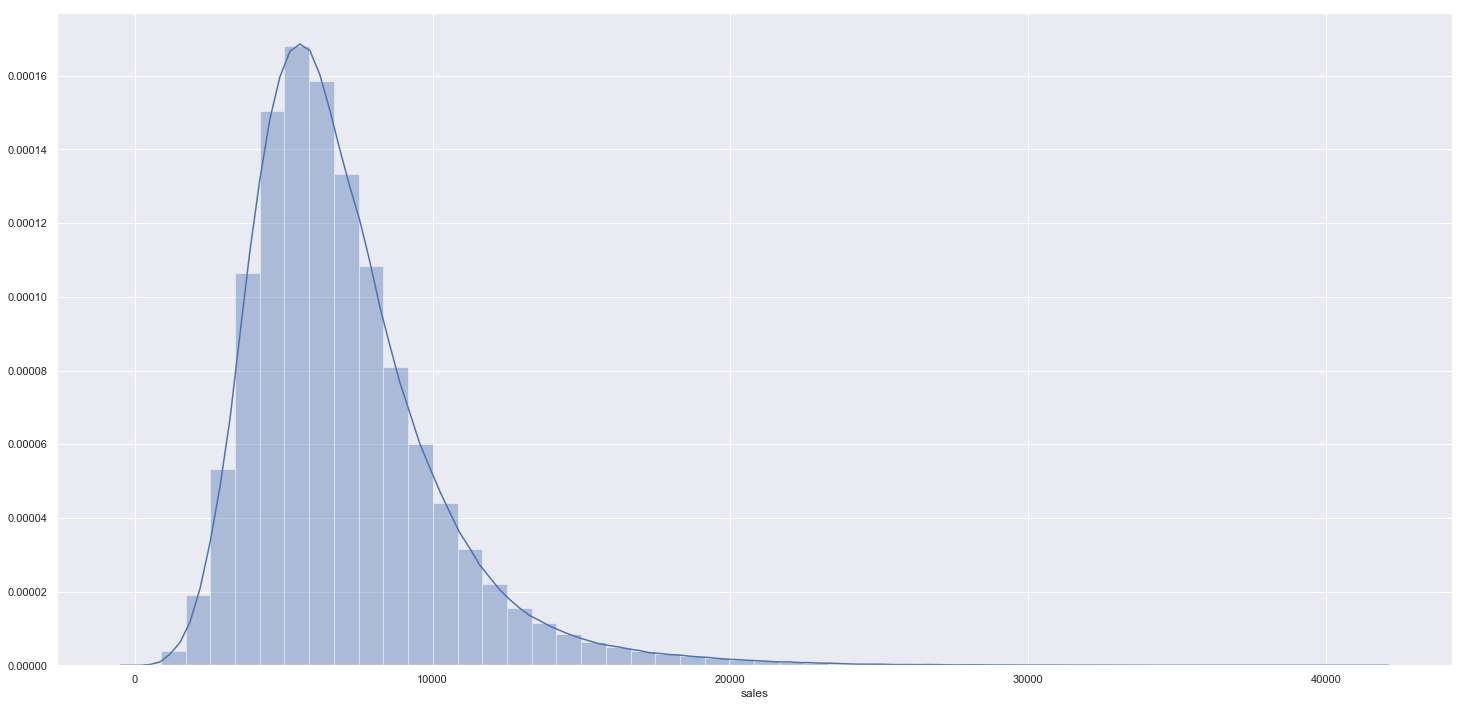

In [39]:
sns.distplot((df4['sales']))

### 4.1.2 Numerical Variable

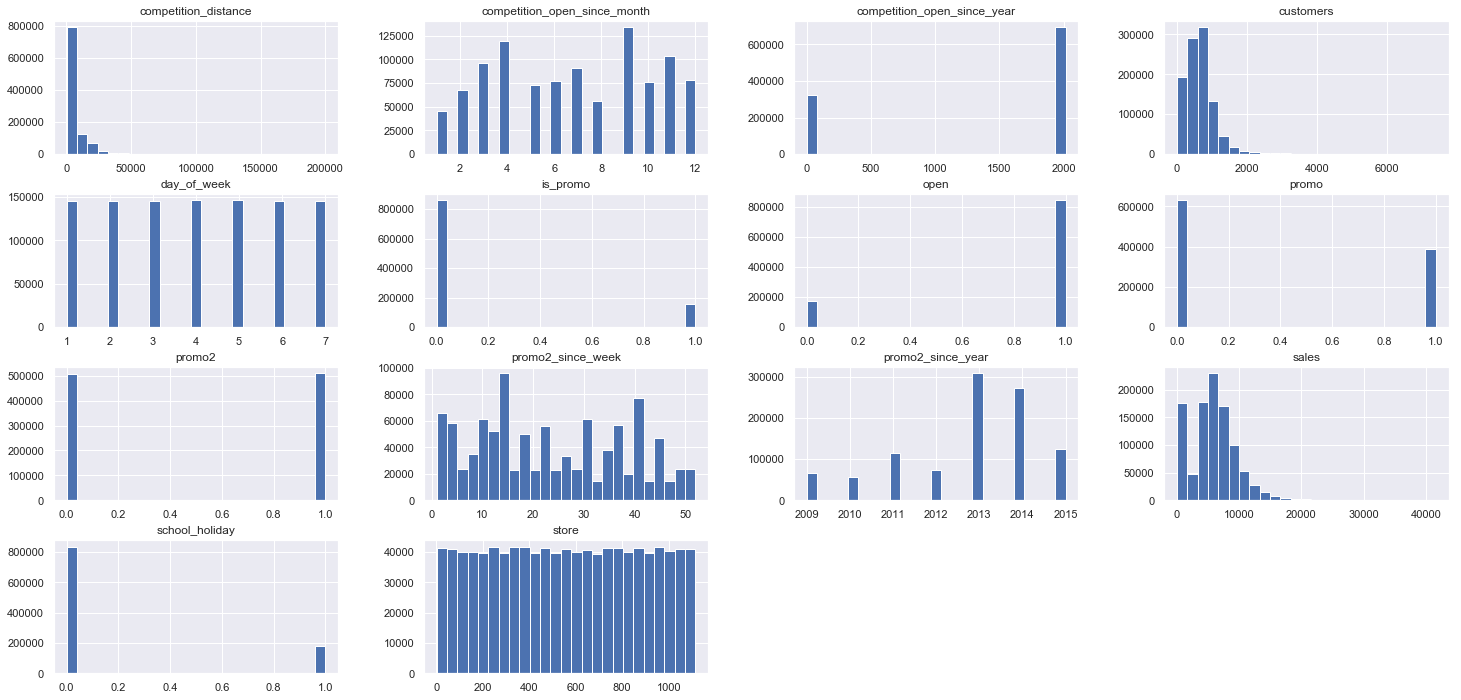

In [40]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical Variable

In [41]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


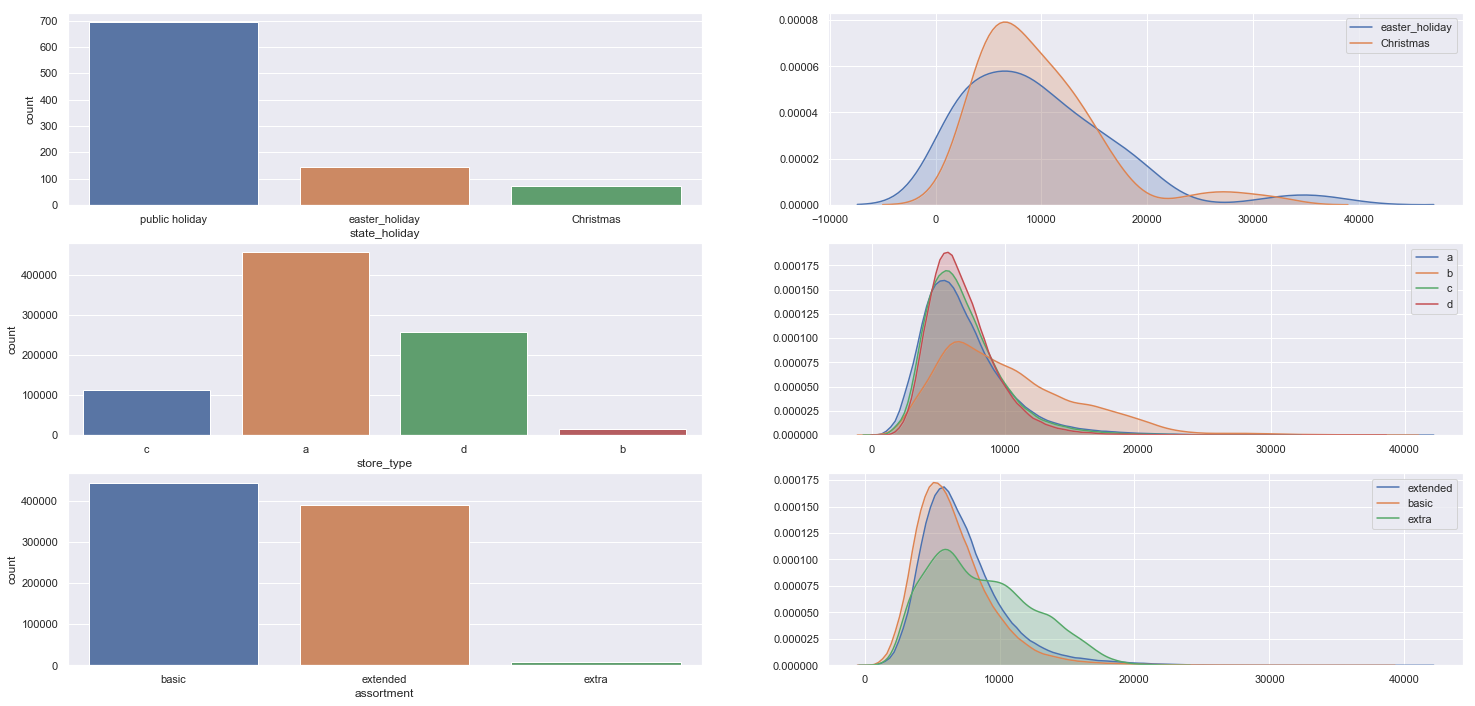

In [42]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 0]
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='Christmas']['sales'], label='Christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label = 'extra', shade=True)

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.
**Falsa** - Lojas com MAIOR SORTIMENTO vendem MENOS.

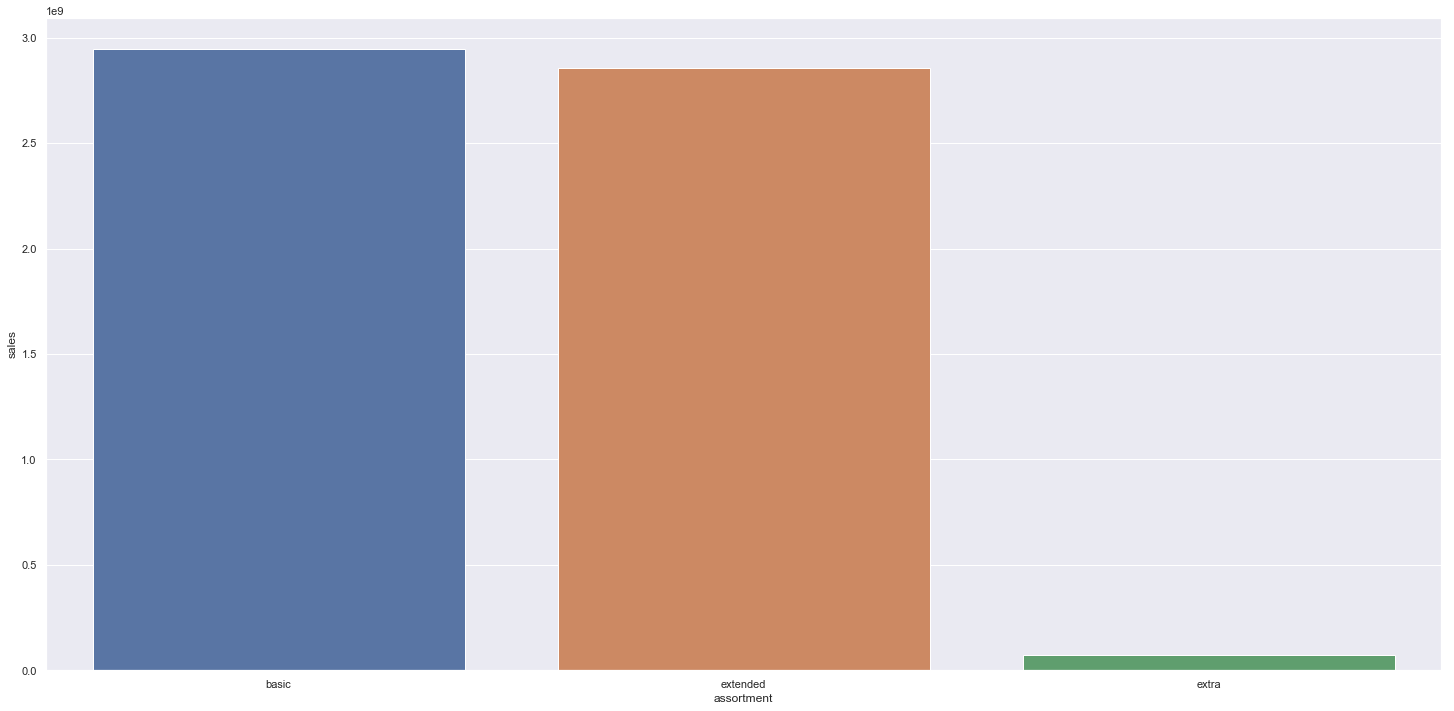

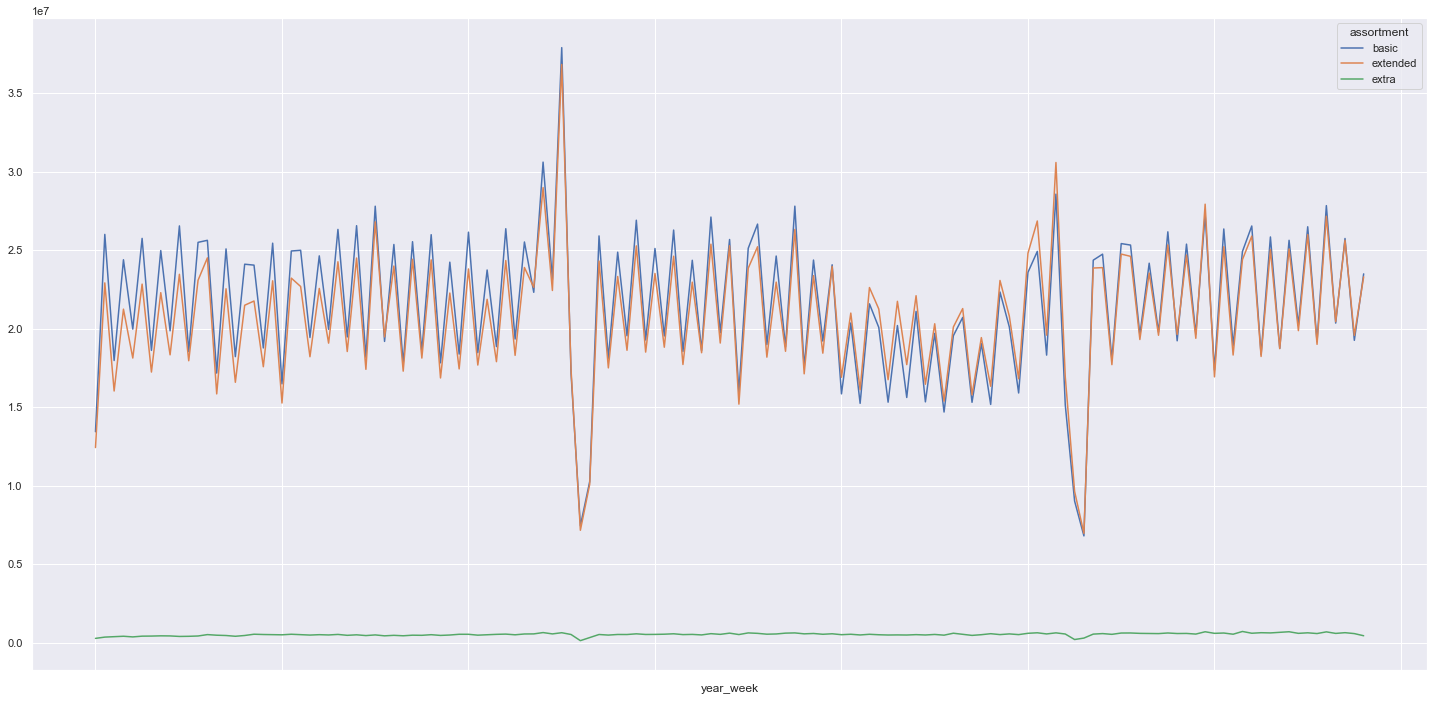

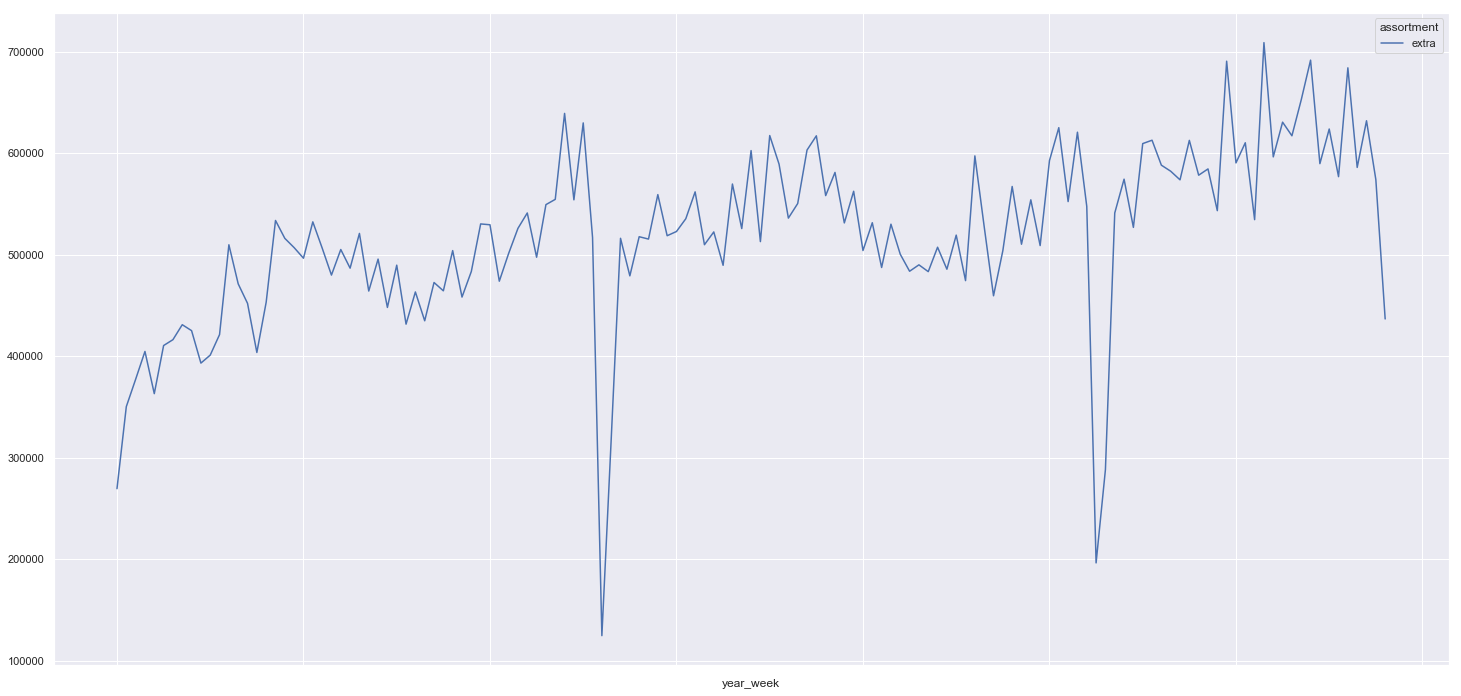

In [43]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2=df4[['year_week', 'assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment', values='sales').plot()

aux3=aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos
**FALSA** Lojas com COMPETITORES PRÓXIMOS vendem MAIS.

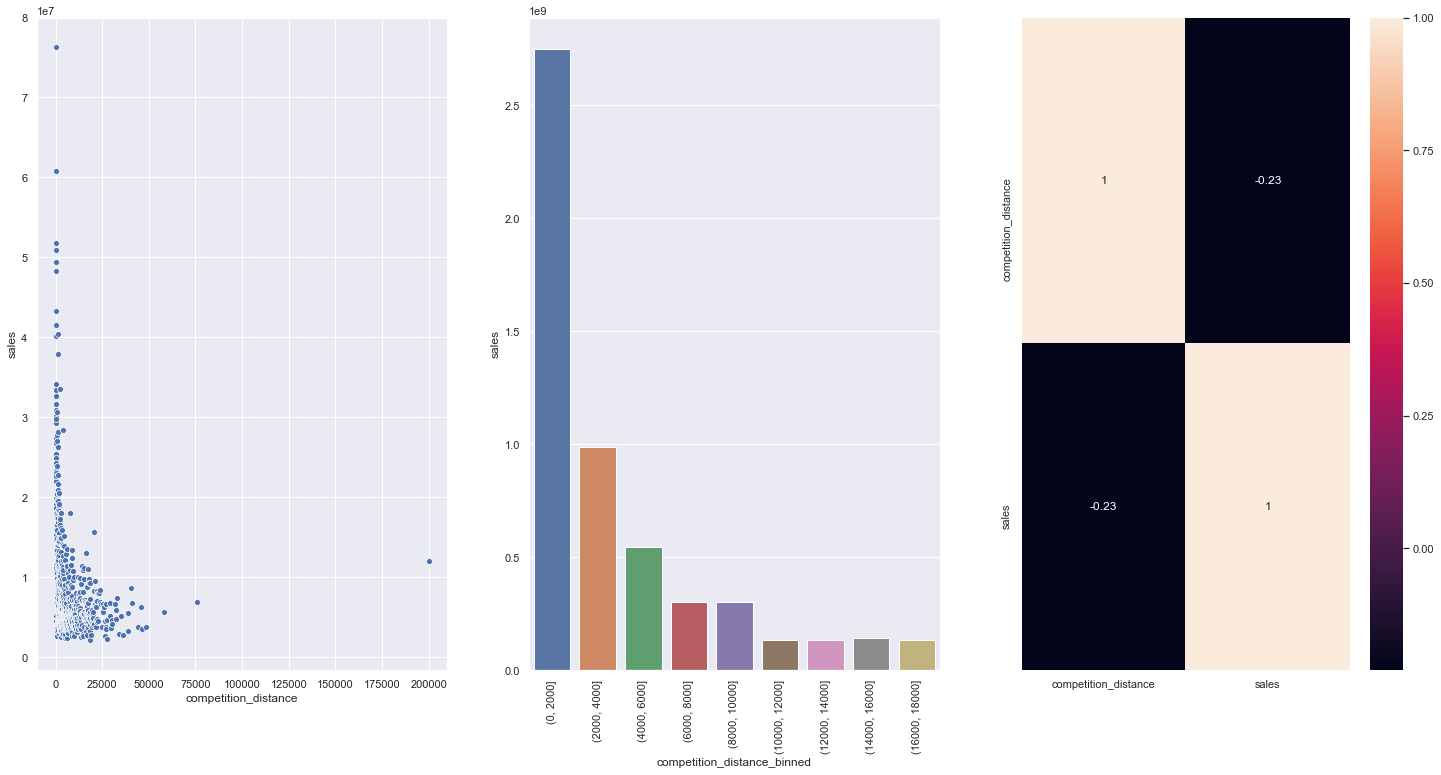

In [44]:
aux4 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales', data=aux4);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 2000))
aux4['competition_distance_binned'] = pd.cut(aux4['competition_distance'], bins=bins)
aux5=aux4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux5)
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux4.corr(method='pearson'), annot=True);

In [45]:
aux1.head()

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


### H3. Lojas com competidores à mais tempo vendem mais.

***FALSA*** Lojas com competidores À MAIS TEMPO vendem MENOS

In [46]:
df4['competition_time_month'] = df4['competition_time_month'].astype(np.int64)

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


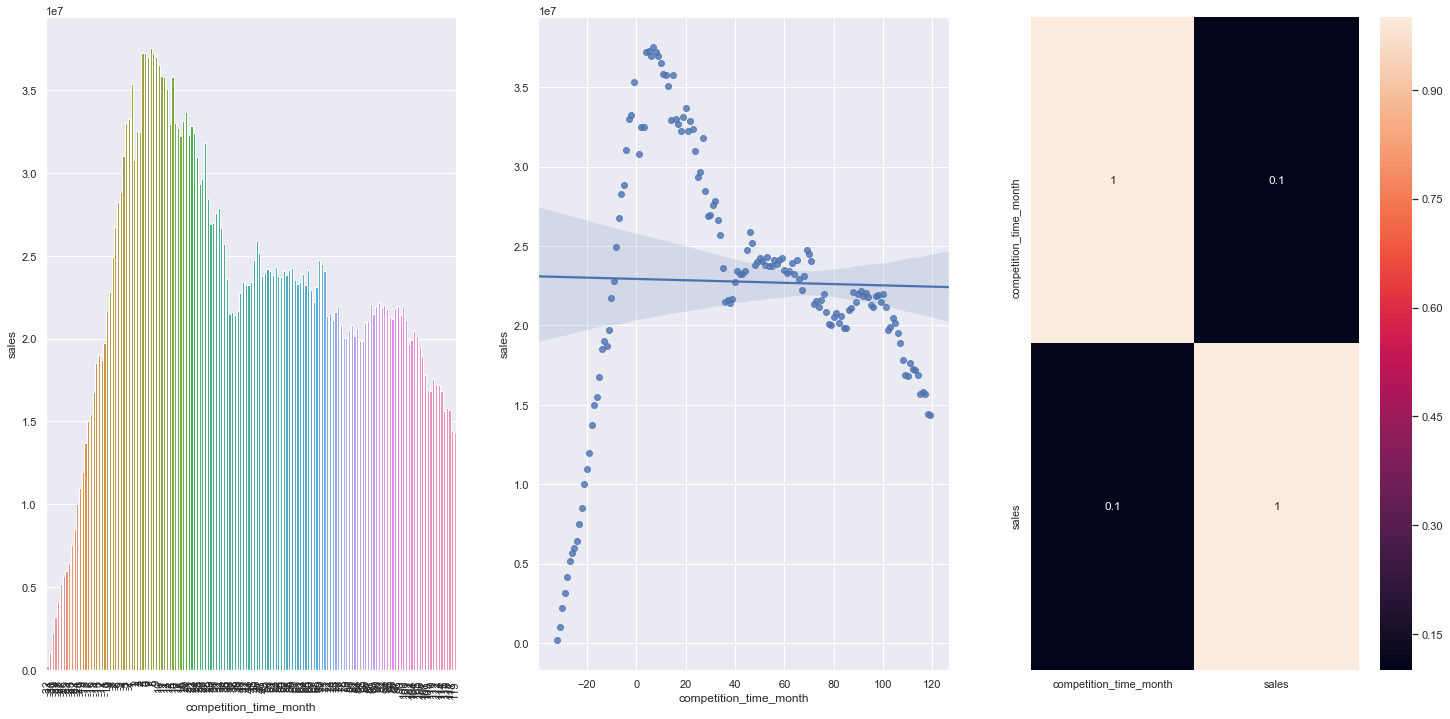

In [47]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x ='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
x= sns.heatmap(aux1.corr (method='pearson'), annot=True);
#bottom, top=x.get_ylim()
#x.set_ylim(bottom+0.5, top-0.5)


### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais
***FALSA*** lojas com promoções ativas por mais tempo vendem MENOS depois de um certo tempo.

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


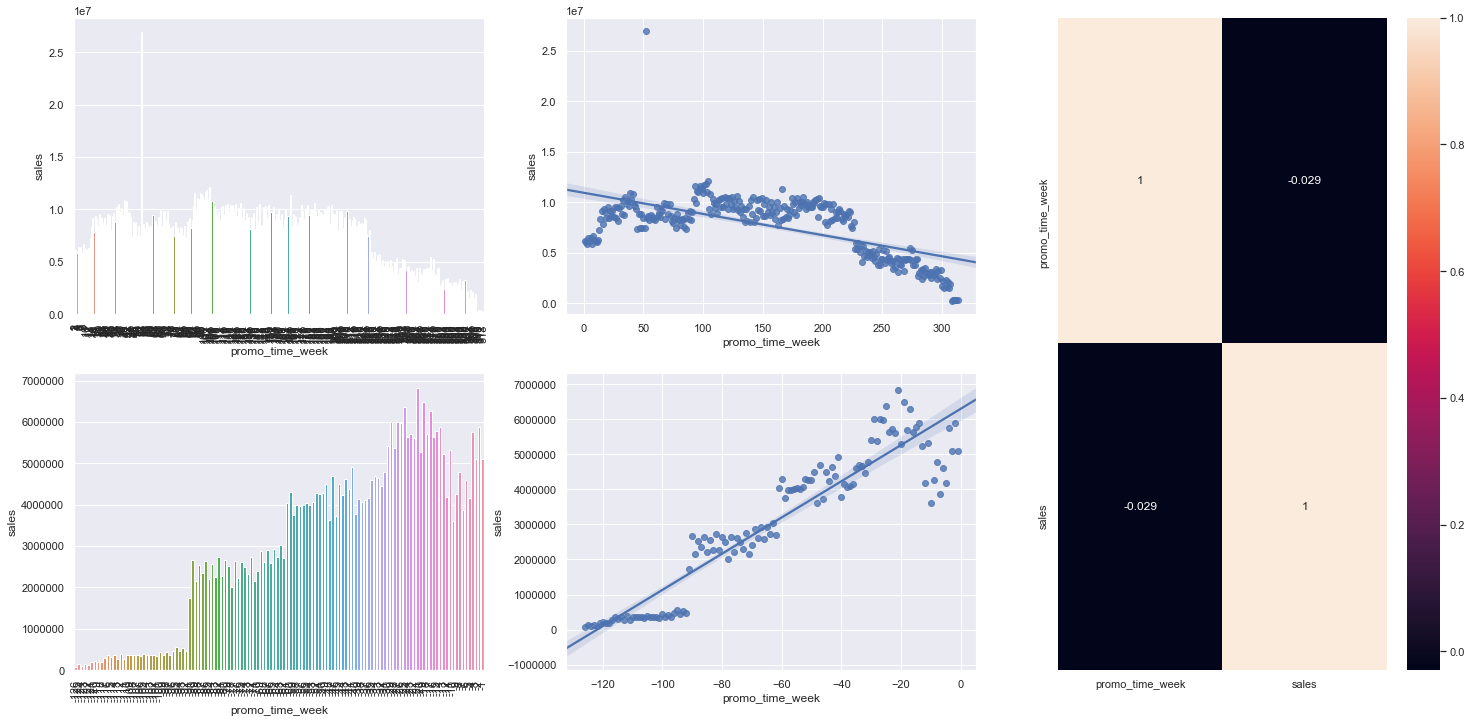

In [48]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H7. lojas com mais promoções consecutivas deveriam vender mais
***FALSA*** Lojas com mais promoções vendem MENOS

In [49]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


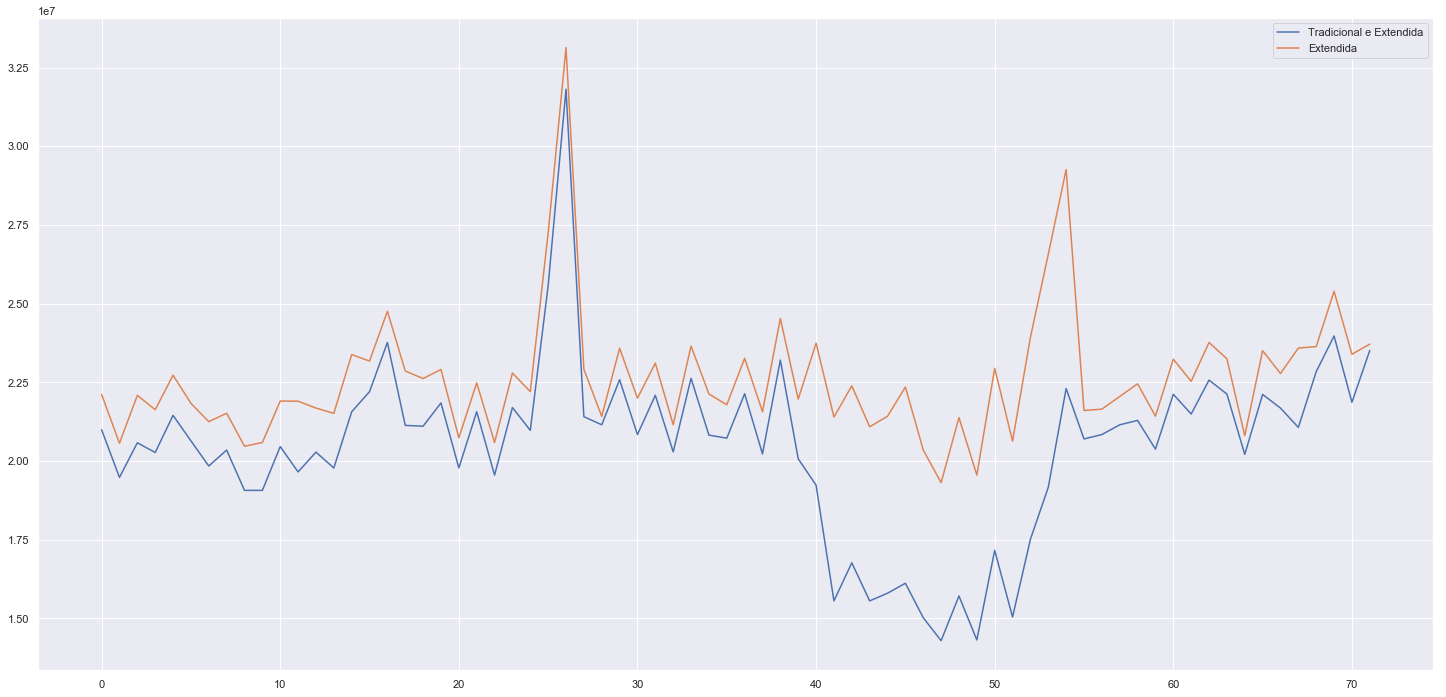

In [50]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index() 
aux2.plot(ax=ax)
ax.legend(labels=['Tradicional e Extendida', 'Extendida'])

## H8. Lojas abertas durante o feriado de Natal deveriam vender mais
***FALSA*** Lojas abertas durante o feriado VENDEM MENOS.

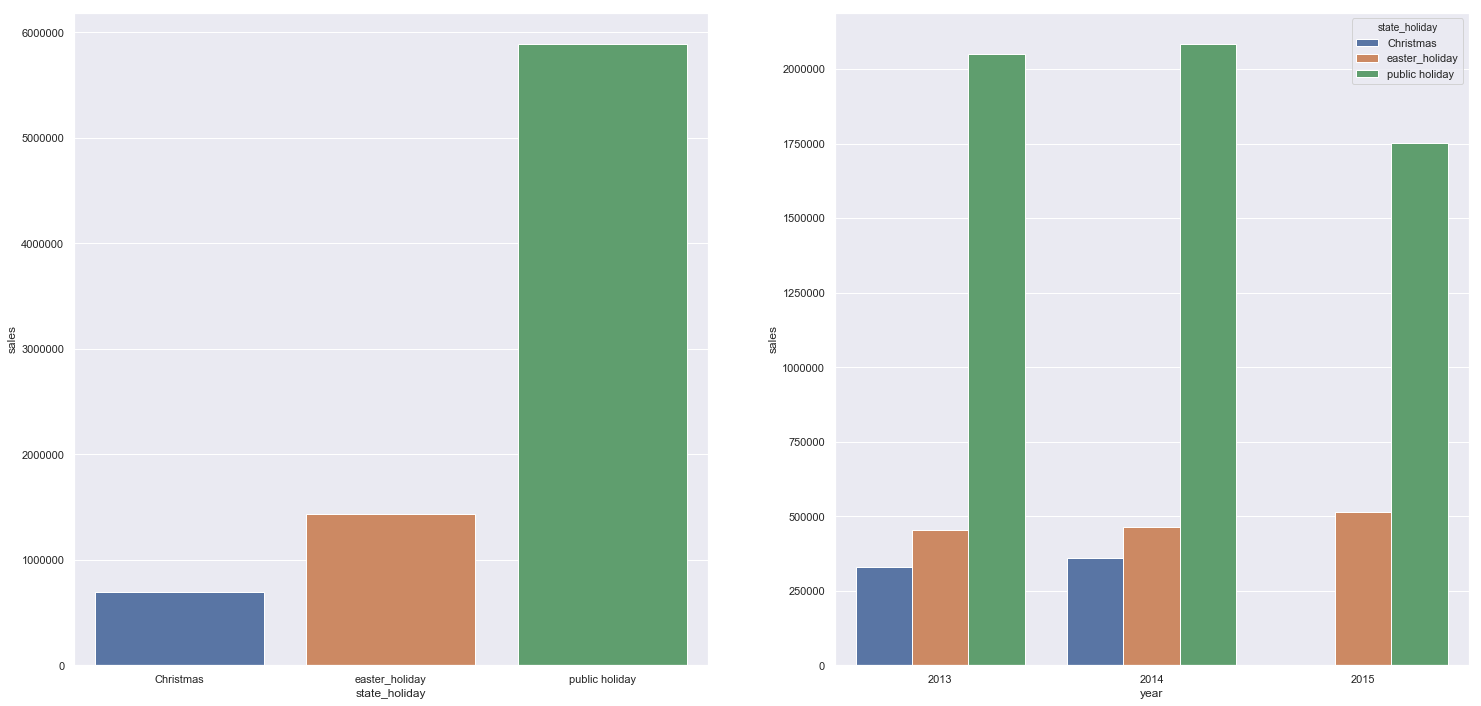

In [51]:
aux = df4[df4['state_holiday'] !=0]

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue = 'state_holiday', data=aux2);

## H9. Lojas deveriam vender mais ao longo dos anos
***FALSA*** Lojas vendem MENOS ao longo dos anos

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


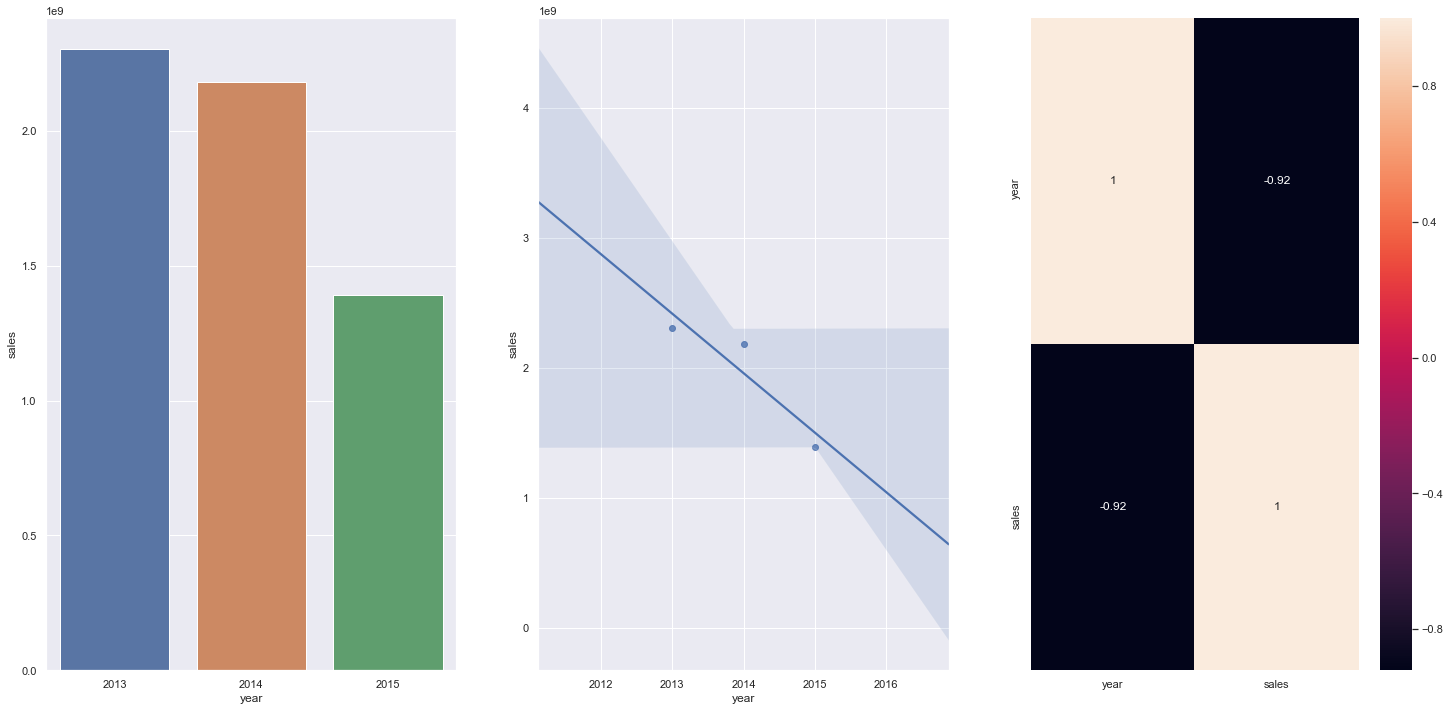

In [52]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### H10. Lojas deveriam vender mais no segundo semestre do ano
***FALSA*** lojas vendem MENOS no segundo semestre do ano

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


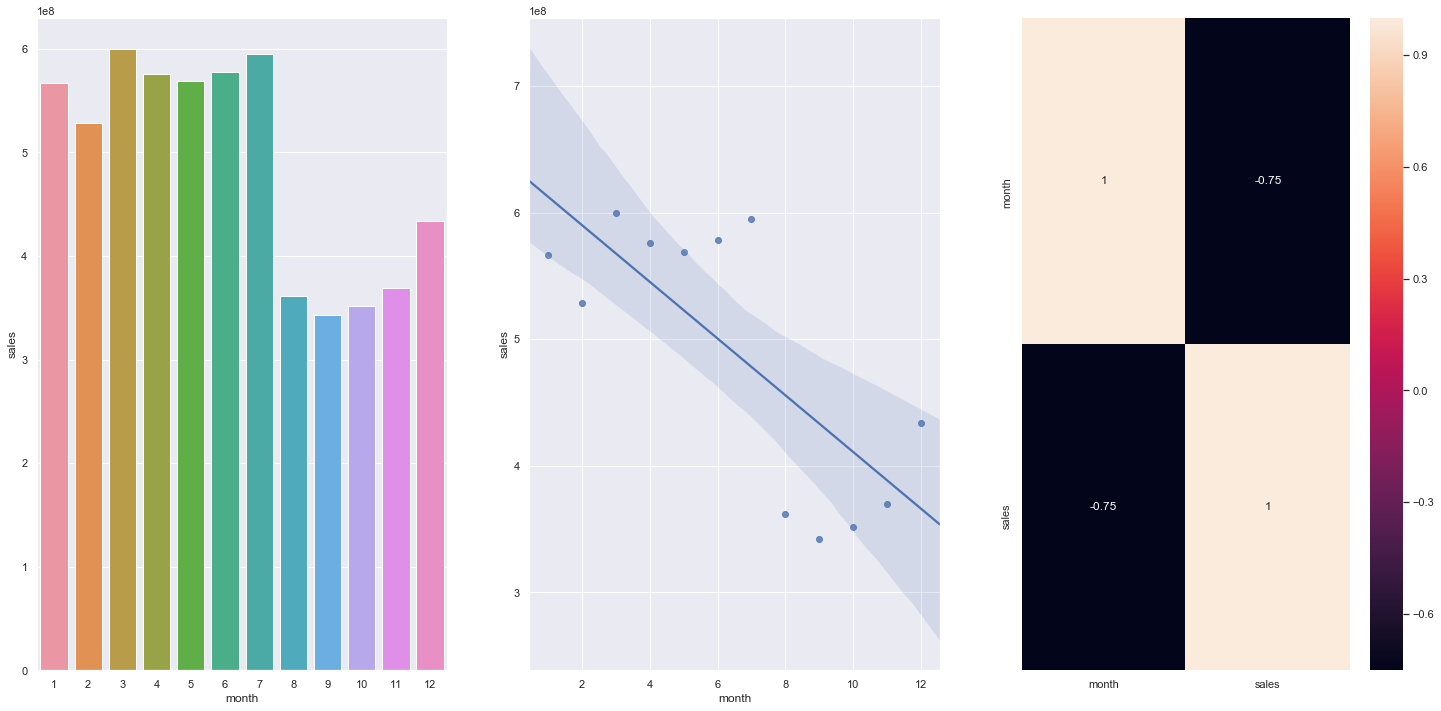

In [53]:
aux1 =df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y= 'sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot= True)

## H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
***VERDADEIRA*** Lojas vendem MAIS depois do dia 10 de cada mês.

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


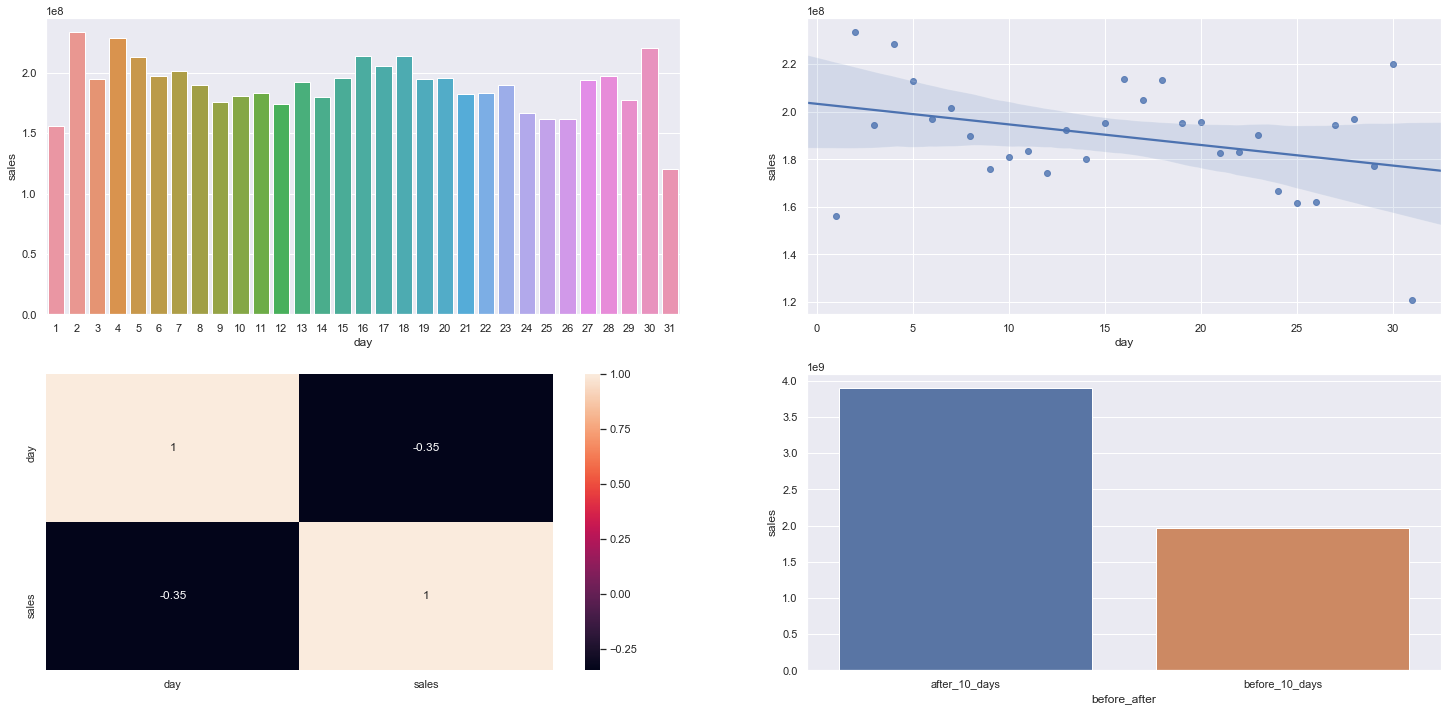

In [54]:
aux1 = df4[['day', 'sales']].groupby ('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after']=aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

## H12. Lojas deveriam vender menos nos fim de semana
***VERDADEIRA*** Lojas vendem MENOS nos fim de semana

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


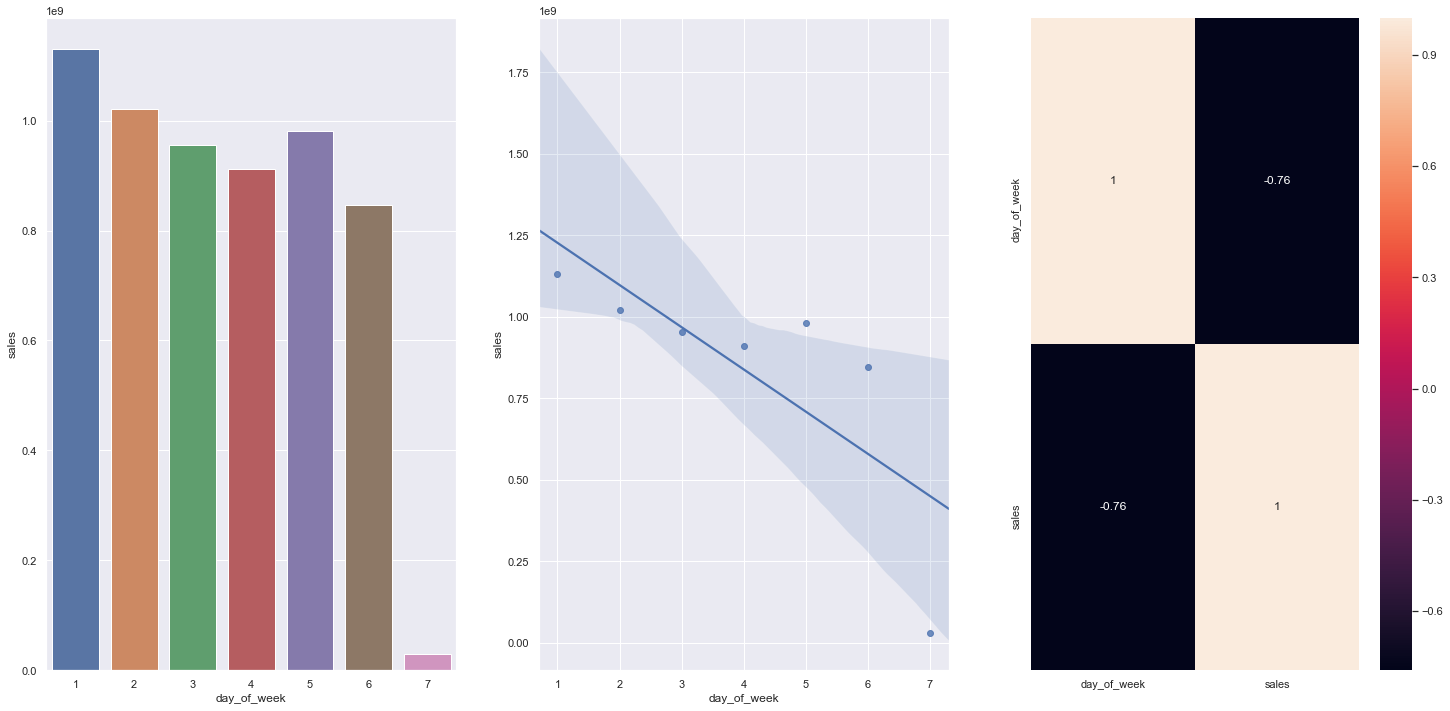

In [55]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H13. Lojas deveriam vender menos durante os feriados escolares
***VERDADEIRA*** Lojas vendem MENOS durante os feriados escolares, except os meses de Julho e Agosto

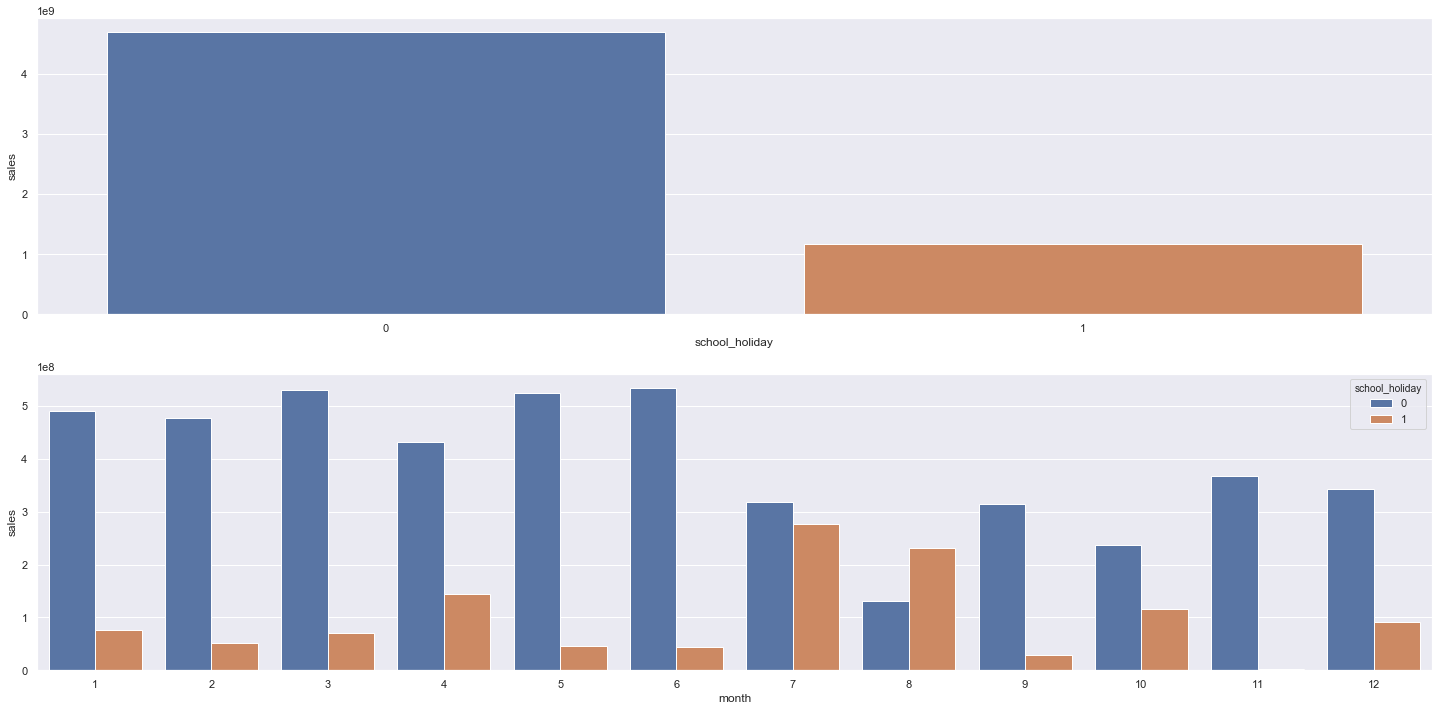

In [56]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## 4.3 Análise Multivarida

## 4.3.1 Numerical Attributes

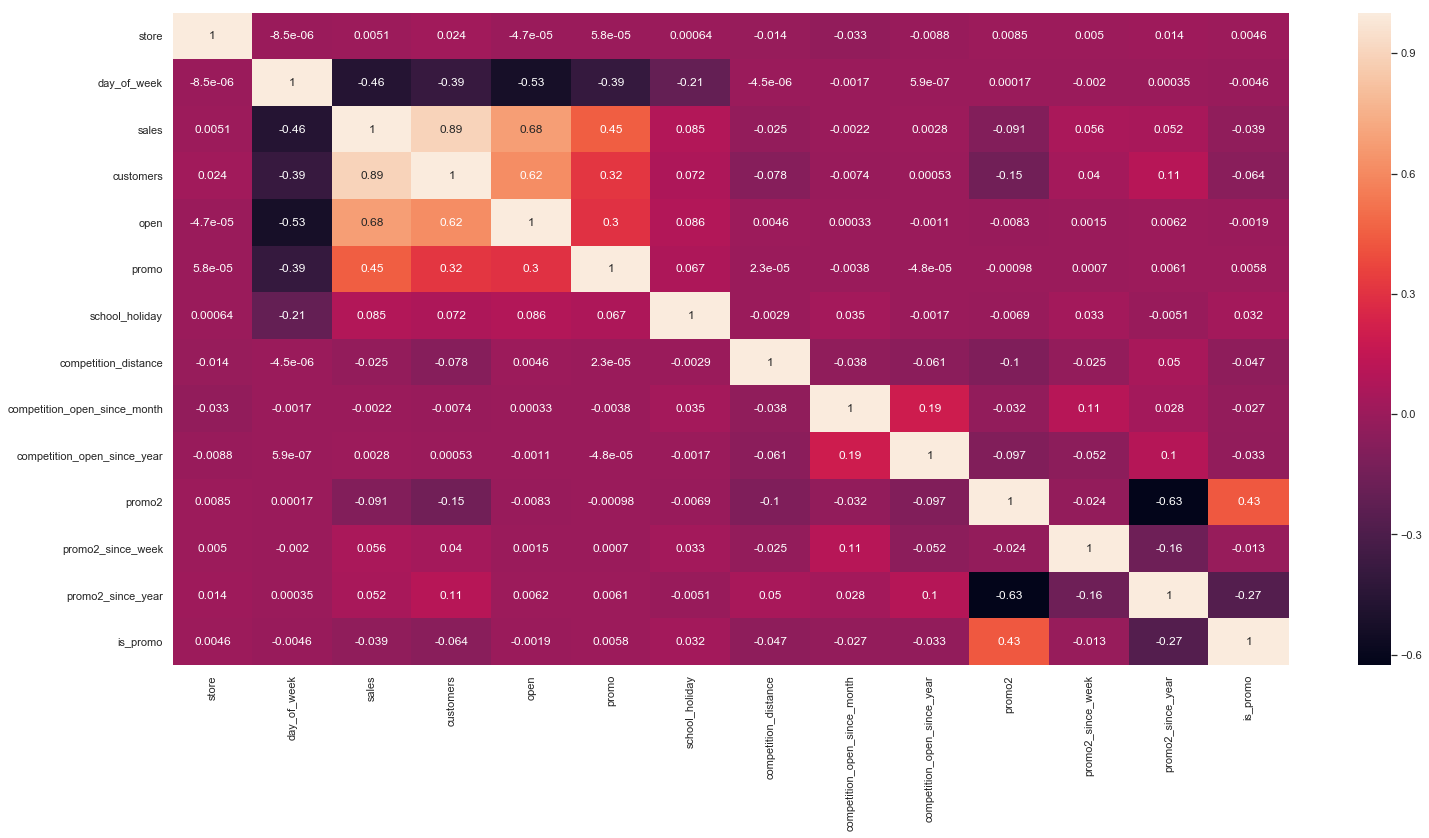

In [58]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

## 4.3.2 Categorical Attributes

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


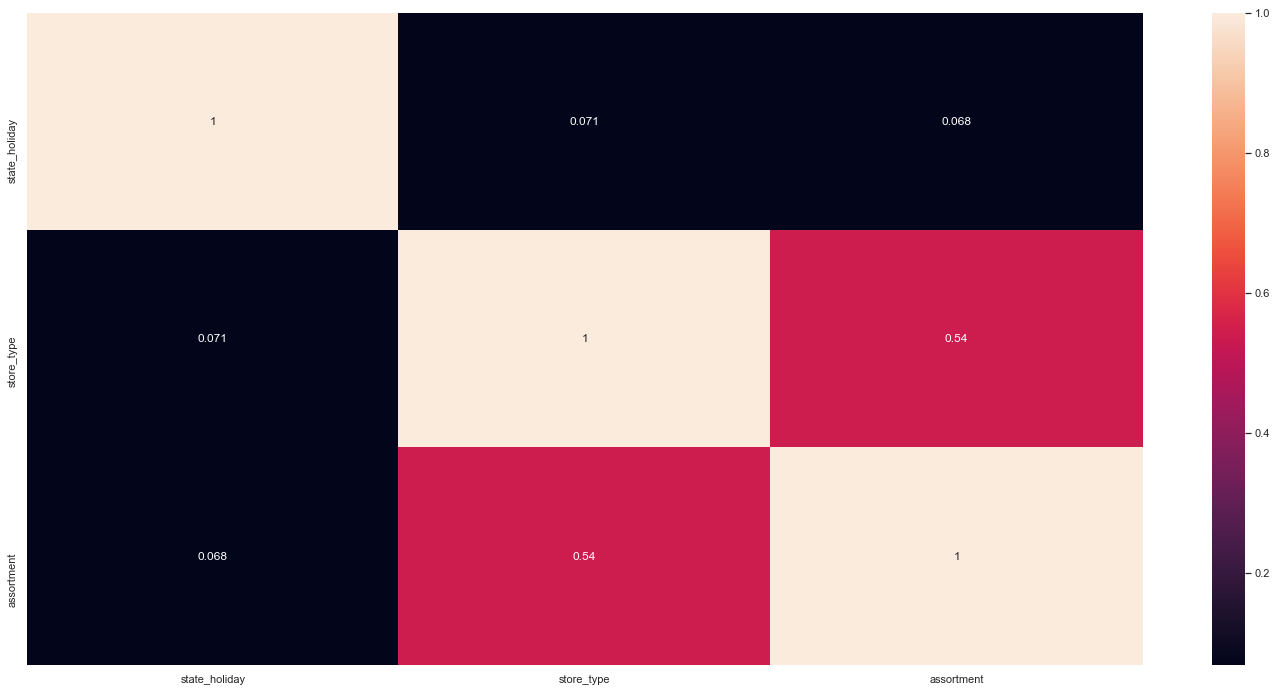

In [59]:
#only categorical data
a = df4.select_dtypes(include = 'object')

#Calculate cramer V
cramer_v(a['state_holiday'],a['store_type'])

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
                 'store_type':[a4,a5,a6],
                 'assortment': [a7,a8,a9]})

d= d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0 PASSO 5 - DATA PREPARATION

In [60]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [61]:
a = df5.select_dtypes(include = ['int64', 'float64'])

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


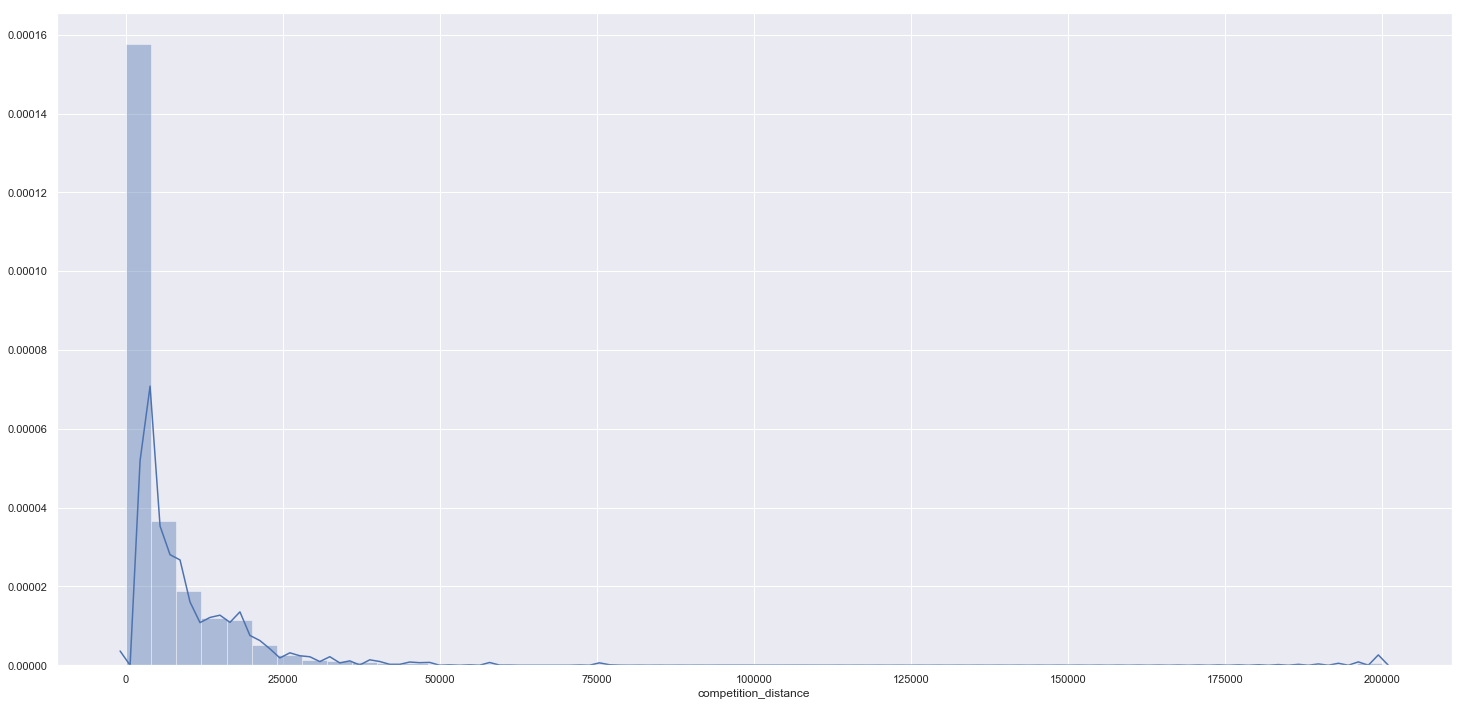

In [62]:
sns.distplot(df5['competition_distance'])

In [63]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## 5.3 Transformacao

### 5.3.1 Enconding

In [64]:
#state_holiday - One Hot Enconding
df5 = pd.get_dummies(df5, prefix = ['satet_holiday'], columns = ['state_holiday'])

#store_type - Label Enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Enconding
assortment_dict = {'basic':1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [65]:
df5['sales'] = np.log1p(df5['sales'])

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


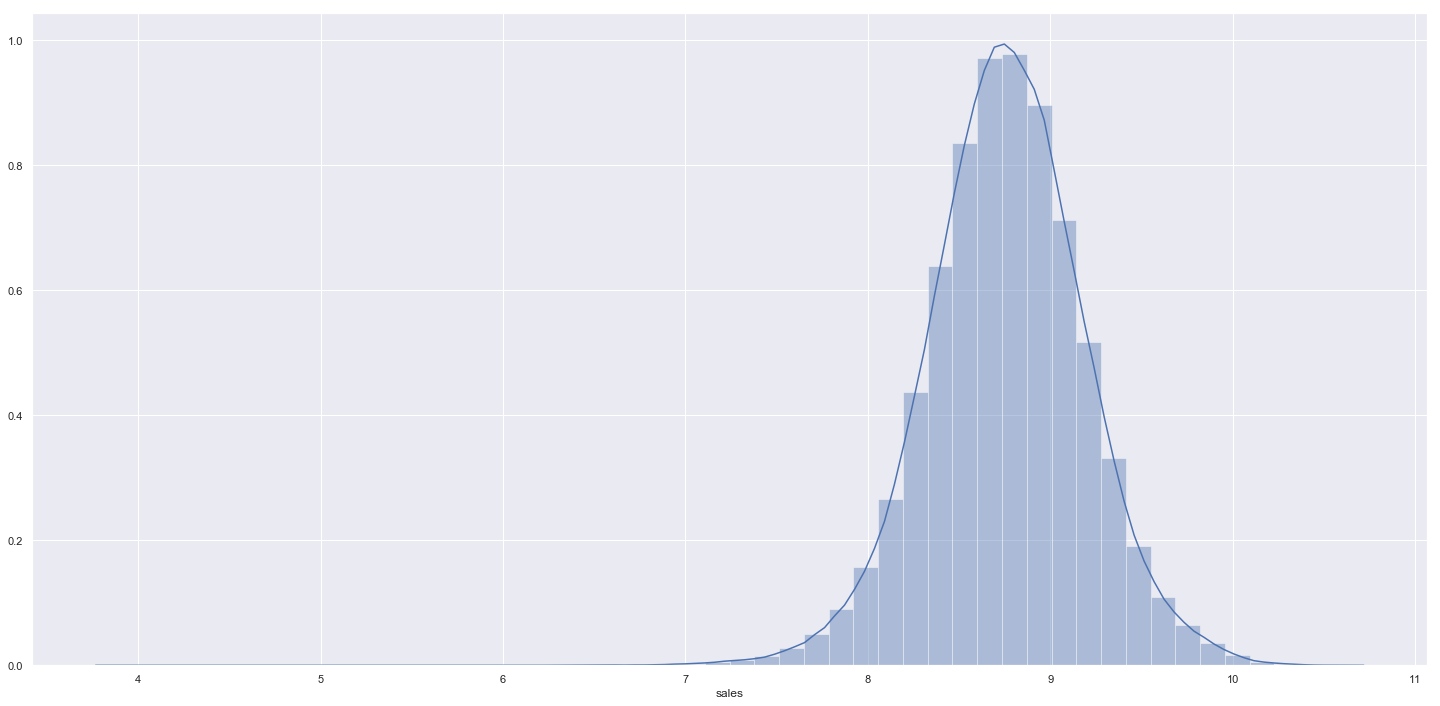

In [66]:
sns.distplot(df5['sales'])

In [67]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week,competition_time_month,satet_holiday_False,satet_holiday_Christmas,satet_holiday_easter_holiday,satet_holiday_public holiday
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,2015-07-27,0.287016,-0.005806,1,0,0,0
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,2010-03-22,0.922551,0.001451,1,0,0,0
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,2011-03-28,0.801822,0.009434,1,0,0,0
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,2015-07-27,0.287016,-0.015239,1,0,0,0
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,2015-07-27,0.287016,-0.063861,1,0,0,0


In [68]:
#day 
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

#day of week
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2. * np.pi/7)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2. *  np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2. *  np.pi/12)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(2. * np.pi/52))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(2. * np.pi/52))

In [69]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week,competition_time_month,satet_holiday_False,satet_holiday_Christmas,satet_holiday_easter_holiday,satet_holiday_public holiday,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,2015-07-27,0.287016,-0.005806,1,0,0,0,0.207912,0.978148,-0.5,-0.866025,0.120537,0.992709
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,2010-03-22,0.922551,0.001451,1,0,0,0,0.207912,0.978148,-0.5,-0.866025,0.120537,0.992709
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,2011-03-28,0.801822,0.009434,1,0,0,0,0.207912,0.978148,-0.5,-0.866025,0.120537,0.992709
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,2015-07-27,0.287016,-0.015239,1,0,0,0,0.207912,0.978148,-0.5,-0.866025,0.120537,0.992709
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,2015-07-27,0.287016,-0.063861,1,0,0,0,0.207912,0.978148,-0.5,-0.866025,0.120537,0.992709


# 6.0 PASSO 6 - FEATURE SELECTION

In [1]:
df6 = df5.copy()

NameError: name 'df5' is not defined

## 6.1 Split dataframe into training and test dataset

In [71]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week,competition_time_month,satet_holiday_False,satet_holiday_Christmas,satet_holiday_easter_holiday,satet_holiday_public holiday,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,2015-07-27,0.287016,-0.005806,1,0,0,0,0.207912,0.978148,-0.5,-0.866025,0.120537,0.992709
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,2010-03-22,0.922551,0.001451,1,0,0,0,0.207912,0.978148,-0.5,-0.866025,0.120537,0.992709
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,2011-03-28,0.801822,0.009434,1,0,0,0,0.207912,0.978148,-0.5,-0.866025,0.120537,0.992709
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,2015-07-27,0.287016,-0.015239,1,0,0,0,0.207912,0.978148,-0.5,-0.866025,0.120537,0.992709
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,2015-07-27,0.287016,-0.063861,1,0,0,0,0.207912,0.978148,-0.5,-0.866025,0.120537,0.992709


In [72]:
cols_drop = ['week_of_year', 'day', 'month','day_of_week','promo_since', 'competition_since', 'year_week']

In [73]:
df6 = df6.drop(cols_drop, axis=1)

In [74]:
df6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
5,6,2013-01-02
6,7,2013-01-02
7,8,2013-01-02
8,9,2013-01-02
9,10,2013-01-02


In [75]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0]-datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [77]:
#training dataset
X_train = df6[df6['date']< '2015-06-19']
Y_train = X_train['sales']

#test dataset
X_test = df6[df6['date']>= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date:{}'.format(X_train['date'].min()))
print('Training Max Date:{}'.format(X_train['date'].max()))

print('\nTraining Min Date:{}'.format(X_test['date'].min()))
print('Training Max Date:{}'.format(X_test['date'].max()))

Training Min Date:2013-01-01 00:00:00
Training Max Date:2015-06-18 00:00:00

Training Min Date:2015-06-19 00:00:00
Training Max Date:2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [ ]:
#Training and test dataset for Boruta
X_train_n = X_train.drop(['date','sales'], axis=1).values
Y_train_n = Y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

#define Boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0


### 6.2.1. Best Features from Boruta

In [92]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### 6.3 Manual Feature Selection

In [132]:
cols_selected_boruta =['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'competition_time_month',
 'day_sin',
 'day_cos',
 'month_cos']

#columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [115]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'competition_time_month',
 'day_sin',
 'day_cos',
 'month_cos']

# 7.0 PASSO 7 - MACHINE LEARNING MODELLING

In [146]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [120]:
y_train = Y_train

In [118]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

## 7.1 Average Model

In [122]:
y_test = Y_test

In [123]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
#y_test = aux1['sales']

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [124]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1902.120691,0.300749,2703.194296


### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

## 7.3 Linear Regression Regularized Model - Lasso

In [125]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))

lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1906.419107,0.291804,2760.83857


### 7.3.1 Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

## 7.4 Random Forest Regressor

In [126]:
#model
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,958.862049,0.151146,1318.776319


### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv

## 7.5 XGBoost Regressor

In [127]:
#model
model_xgb = xgb.XGBRegressor(Objective ='reg:squarederror',
                            n_estimators = 100,
                            eta = 0.01,
                            max_depth = 10,
                            subsample = 0.7,
                            colsample_bytee = 0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[20:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { Objective, colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6681.000998,0.949144,7327.610816


### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
xgb_result_cv

## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [145]:
modelling_result = pd.concat([baseline_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,958.862049,0.151146,1318.776319
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression - Lasso,1906.419107,0.291804,2760.838570
0,XGBoost Regressor,6681.000998,0.949144,7327.610816


In [142]:
x_training = X_train[cols_selected_boruta_full]

In [184]:
def cross_validation (x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range(1, kfold+1)):
        if verbose:
            print('\nKFold Number:{}'.format(k))
         #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date']< validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = training['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict( xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
            
        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
            
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)})
            

In [ ]:
model = LinearRegression()
a = cross_validation(x_training, 5, 'Linear Regression', model, verbose = True)

### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result, rf_result, xgb_result_cv])
modelling_result_cv.sort_values('RMSE')